In [30]:
import pandas as pd
import numpy as np
import polars as pl
import time
import matplotlib.pyplot as plt


### Let's open up the DF - assess how many participants remain after removing those with not enough data

In [32]:
#set path to REMOTES folder
path = '../../../data'

# Load the data
df = pd.read_csv(f'{path}/sensors_data.csv')

#open and read the text file with patient IDs to remove 
import ast

with open(f'{path}/exclude_IDs.txt') as f:
    lines = f.read()  # Read the entire content
    patients_to_remove = ast.literal_eval(lines)  # Safely evaluate the string as a list

print(len(patients_to_remove))


df = df[~df['Patient ID'].isin(patients_to_remove)]

print(len(df))

39
164


### 29 files removed for several reasons:
### - 5 files have under 24 hours of recorded data 
### - 17 files have under 16 hours of HR in first 24 hours
### - 5 files with over significant ectopic beats in recorded 5min period
### - 1 file corrupted


### Now open up the demographic data and combine with the WS data usign the study ID value
### Also remove any participants who have a 0 value for their CPET (representing incomplete testing) 

In [21]:
#open the demo_data file 
demo_data = pd.read_csv(f'{path}/demo_data.csv')

#change the column title from study_id to Patient ID
demo_data = demo_data.rename(columns={'study_id': 'Patient ID'})

#merge the demo_data with the WS_data only keeping columns 'cpet_quality', cpet_bike, vo2peak_measured, anaerobic_threshold, bmi, age, gender
df = pd.merge(df, demo_data[['Patient ID', 'cpet_quality', 'cpet_bike', 'vo2peak_measured', 'anaerobicthreshold', 'bmi', 'gender', 'height', 'age']], on='Patient ID', how='left')

#if cpet_bike is 2, multiply vo2peak_measured by 0.9
df['vo2peak_measured'] = np.where(df['cpet_bike'] == 2, df['vo2peak_measured'] * 0.9, df['vo2peak_measured'])



#remove any patient no or 0 value in the column VO2peak_measured and print their patient IDs
print(df[df['vo2peak_measured'] == 0]['Patient ID'])

df = df[df['vo2peak_measured'] != 0]


print(len(df))

22    R035
Name: Patient ID, dtype: object
163


## Print out the characteristics of cohort by gender split

In [22]:
for gender in [1, 0]:
    print(f"\nFor Gender = {gender}:")
    
    variables = ['age', 'bmi', 'vo2peak_measured', 'Wear time', 'steps']
    for var in variables:
        mean_value = df.loc[df['gender'] == gender, var].mean()
        std_value = df.loc[df['gender'] == gender, var].std()
        print(f"Average {var}: {mean_value:.2f}")
        print(f"{var} Standard Deviation: {std_value:.2f}")



For Gender = 1:
Average age: 68.50
age Standard Deviation: 10.25
Average bmi: 28.15
bmi Standard Deviation: 4.98
Average vo2peak_measured: 18.81
vo2peak_measured Standard Deviation: 4.74
Average Wear time: 74.33
Wear time Standard Deviation: 16.29
Average steps: 3854.15
steps Standard Deviation: 3091.37

For Gender = 0:
Average age: 66.91
age Standard Deviation: 13.42
Average bmi: 30.39
bmi Standard Deviation: 7.53
Average vo2peak_measured: 15.19
vo2peak_measured Standard Deviation: 3.71
Average Wear time: 74.04
Wear time Standard Deviation: 18.22
Average steps: 2749.48
steps Standard Deviation: 2233.01


### Run inital correlation anaylsis to investigate initial analysis and identify strongest linear relationships with VO2max

In [23]:
ws = ['steps', 'MVPA steps', 'age',
        'RMSSD', 'SDNN', 'pNN50', 'MeanNN',
       'Resting HR', 'Max HR', 'Min HR', 'Time in MVPA', 'Time in LPA',
       'Time in SB', 'MVPA HR', 'LPA HR', 'SB HR', 
        'Q1', 'Q2', 'Q3', 'Q95', 'LF', 'HF', 'VLF',
       'LF_HF', 'SD1', 'SD2', 'SDNN24',
       'SDNNhr_1min', 'SDNNhr_5min', 'SDNNhr_10min', 'SDNNhr_30min', 'SDNNhr_1hr',
       'gender', 'bmi']

print(len(ws))

from scipy.stats import pearsonr
import pandas as pd

# Significance threshold
SIGNIFICANCE_LEVEL = 0.05

# Initialize lists to store results
correlation_results = []

# Loop through each variable in ws to calculate correlation and p-values
for var in ws:
    if var != 'vo2peak_measured':  # Avoid self-correlation
        # Drop rows with missing values for both 'var' and 'vo2peak_measured'
        valid_data = df[[var, 'vo2peak_measured']].dropna()
        corr, p_val = pearsonr(valid_data[var], valid_data['vo2peak_measured'])
        
        # Add a star if p-value is below the significance threshold
        significance = "*" if p_val < SIGNIFICANCE_LEVEL else ""
        correlation_results.append([var, corr, p_val, significance])

# Convert results to a DataFrame
correlation_df = pd.DataFrame(
    correlation_results, 
    columns=['Variable', 'Correlation', 'P-value', 'Significance']
)

# Add significance stars to the correlation column
correlation_df['Correlation'] = correlation_df['Correlation'].apply(
    lambda x: f"{x:.3f}"
)
correlation_df['P-value'] = correlation_df['P-value'].apply(
    lambda x: f"{x:.3f}"
)
correlation_df['Correlation'] += correlation_df['Significance']

# Drop the significance column (optional) for cleaner output
correlation_df = correlation_df.drop(columns=['Significance'])

# Sort by correlation strength (absolute value)
correlation_df = correlation_df.sort_values(by='Correlation', key=lambda x: x.str.replace('*', '').astype(float).abs(), ascending=False)

# Print the results
print(correlation_df)





34
        Variable Correlation P-value
0          steps      0.509*   0.000
2            age     -0.408*   0.000
31    SDNNhr_1hr      0.354*   0.000
23         LF_HF      0.346*   0.000
30  SDNNhr_30min      0.345*   0.000
32        gender      0.337*   0.000
19           Q95      0.334*   0.000
29  SDNNhr_10min      0.333*   0.000
27   SDNNhr_1min      0.331*   0.000
28   SDNNhr_5min      0.330*   0.000
8         Max HR      0.312*   0.000
1     MVPA steps      0.304*   0.000
26        SDNN24      0.282*   0.000
18            Q3      0.277*   0.000
22           VLF      0.273*   0.000
33           bmi     -0.262*   0.001
20            LF      0.249*   0.001
25           SD2      0.224*   0.004
11   Time in LPA      0.221*   0.005
17            Q2      0.214*   0.006
4           SDNN      0.209*   0.007
9         Min HR     -0.165*   0.035
7     Resting HR     -0.157*   0.045
6         MeanNN       0.153   0.051
16            Q1       0.151   0.054
10  Time in MVPA       0.134   0.08

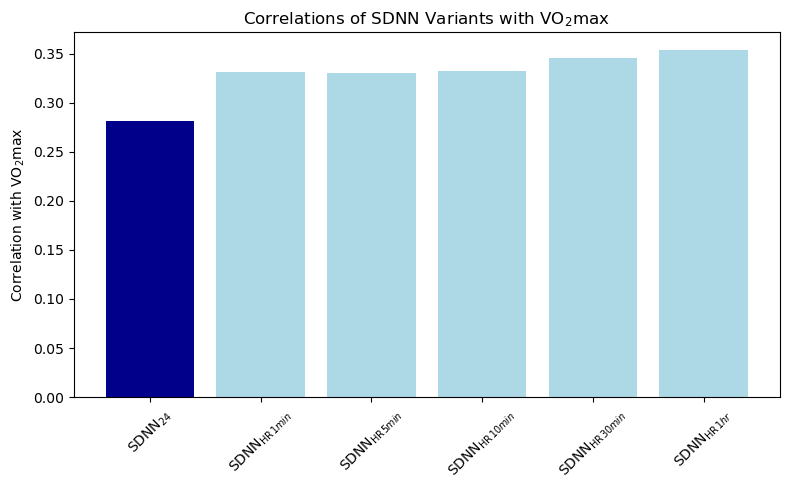

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pandas as pd

# List of SDNN variables to correlate with 'vo2peak_measured'
sdnn_vars = ['SDNN24', 'SDNNhr_1min', 'SDNNhr_5min', 'SDNNhr_10min', 
             'SDNNhr_30min', 'SDNNhr_1hr']

# Initialize a dictionary to store correlation results
correlation_data = {}

# Calculate Pearson correlations for each variable
for var in sdnn_vars:
    # Drop rows with missing values for the specific SDNN variable and vo2peak_measured
    valid_data = df[[var, 'vo2peak_measured']].dropna()
    corr, _ = pearsonr(valid_data[var], valid_data['vo2peak_measured'])
    correlation_data[var] = corr

# Update variable names for labels with proper subscripts
updated_variables = [r"SDNN$_{24}$" if var == 'SDNN24' else r"SDNN$_{\mathrm{HR}}$$_{" + var.split('_')[1].replace('min', 'min').replace('hr', 'hr') + "}$" for var in sdnn_vars]

# Bar chart settings
variables = updated_variables
correlations = list(correlation_data.values())

# Define colors: SDNN24 in darker color, others in lighter color
colors = ['darkblue' if "SDNN$_{24}$" in var else 'lightblue' for var in variables]

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(variables, correlations, color=colors)

# Add labels and title with correct subscripts
plt.ylabel("Correlation with VO$_{2}$max")
plt.title("Correlations of SDNN Variants with VO$_{2}$max")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()


### Run a correlation matrix between features before identifying those with highest collinearity

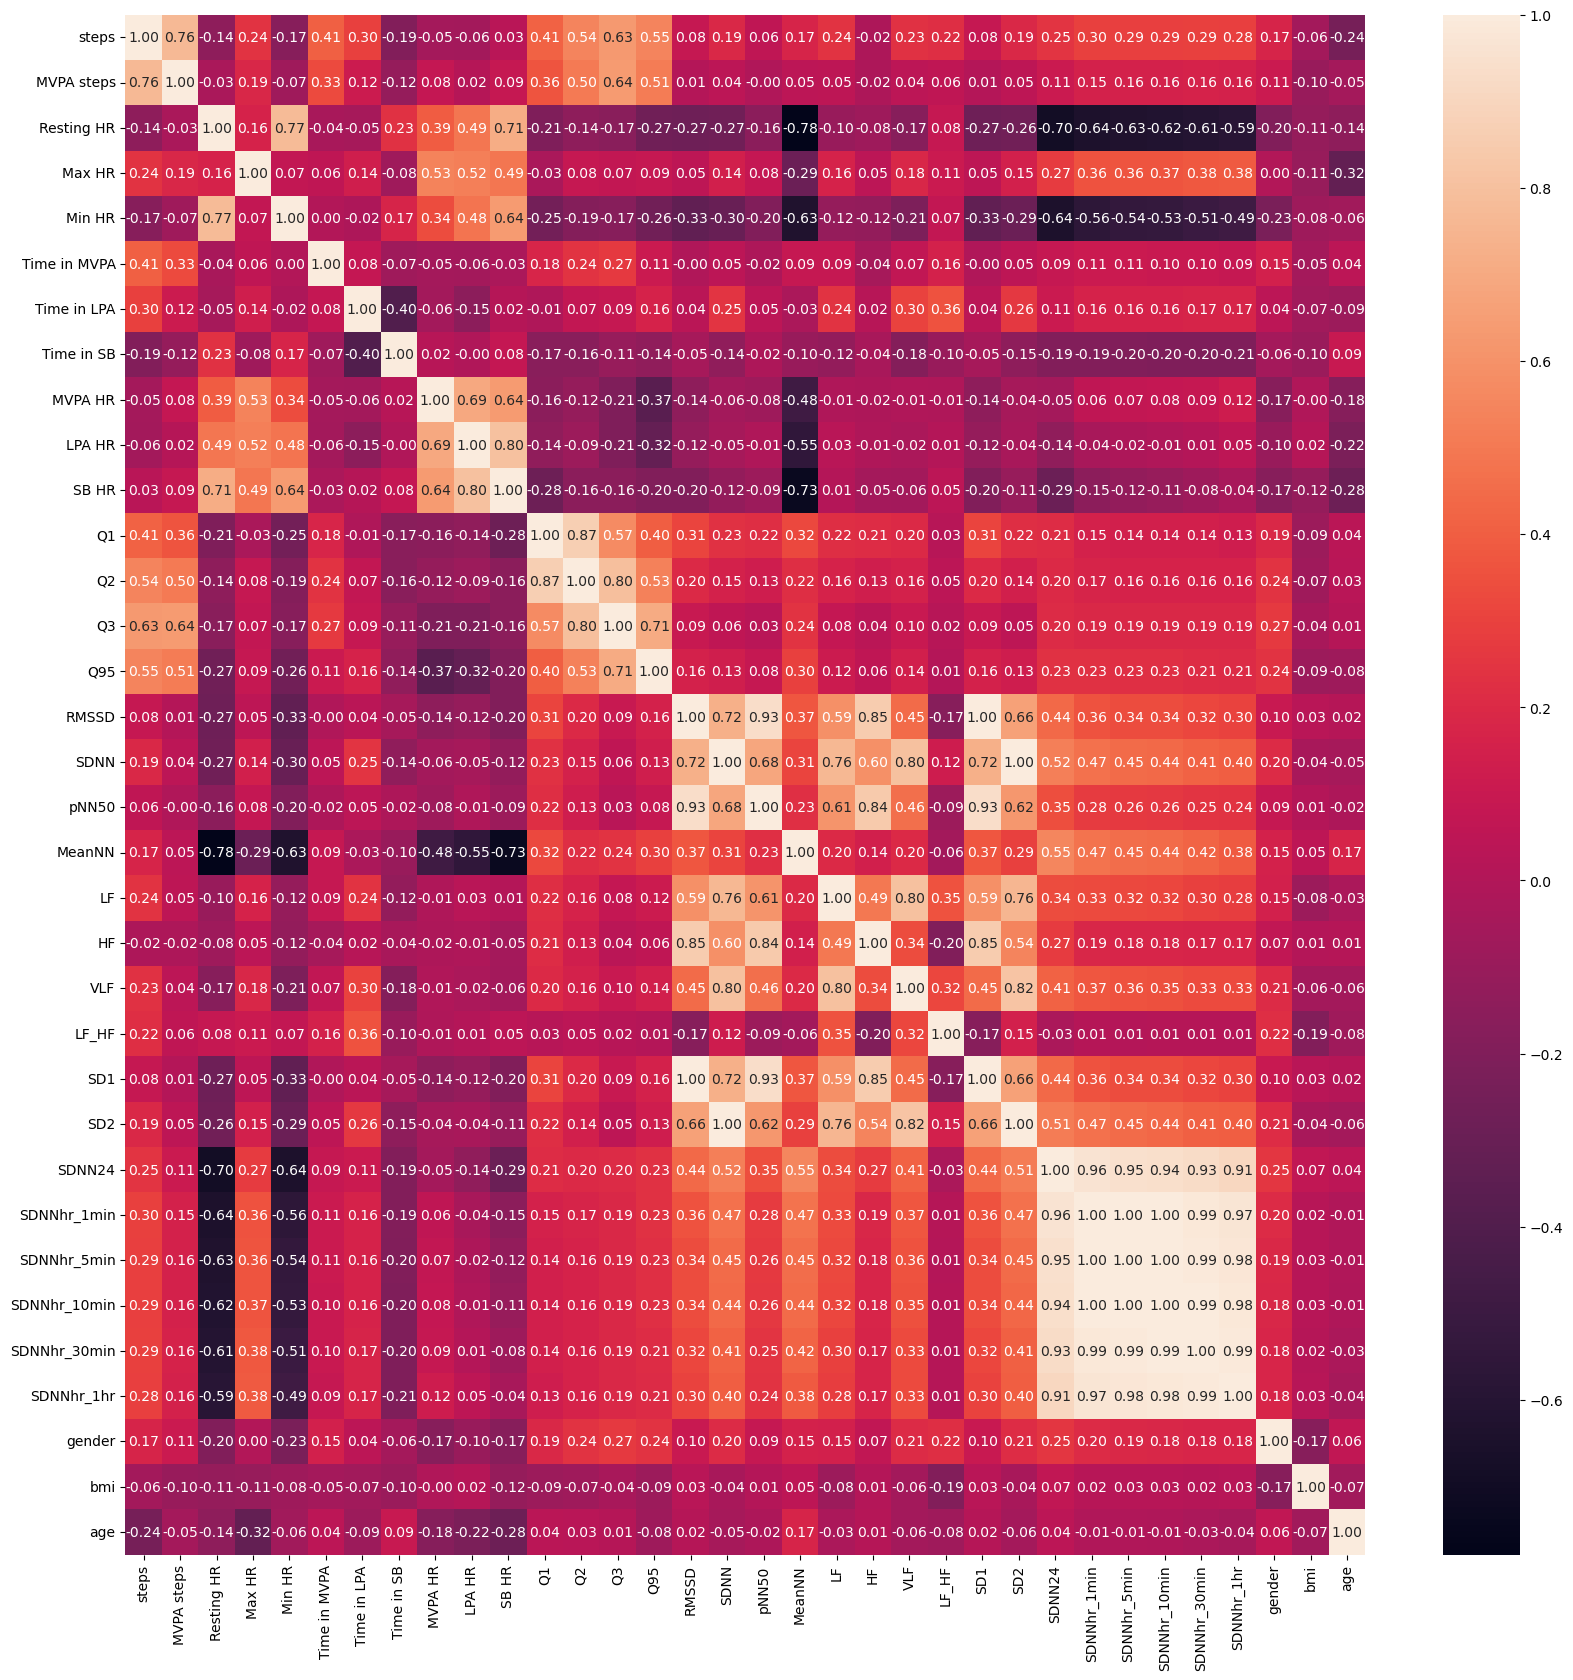

In [25]:
#plot a correlation matrix of all features in df
features = ['steps', 'MVPA steps', 
       'Resting HR', 'Max HR', 'Min HR', 'Time in MVPA', 'Time in LPA',
       'Time in SB', 'MVPA HR', 'LPA HR', 'SB HR', 
        'Q1', 'Q2', 'Q3', 'Q95', 'RMSSD', 'SDNN', 'pNN50', 'MeanNN','LF', 'HF', 'VLF',
       'LF_HF', 'SD1', 'SD2', 'SDNN24',
       'SDNNhr_1min', 'SDNNhr_5min', 'SDNNhr_10min', 'SDNNhr_30min', 'SDNNhr_1hr',
       'gender', 'bmi', 'age']

#using seaborn plot a correlation matrix of all features in df
import seaborn as sns
plt.figure(figsize=(20,20))
sns.heatmap(df[features].corr(), annot=True, fmt=".2f")
plt.show()

In [26]:
# Calculate the correlation matrix
correlation_matrix = df[features].corr()

# Find pairs of features with a correlation above 0.9
threshold = 0.9
high_corr_pairs = []

for i in range(len(features)):
    for j in range(i + 1, len(features)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append(
                (features[i], features[j], correlation_matrix.iloc[i, j])
            )

# Print the pairs with high correlation
print("Features with correlation above 0.9:")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

Features with correlation above 0.9:
RMSSD and pNN50: 0.93
RMSSD and SD1: 1.00
SDNN and SD2: 1.00
pNN50 and SD1: 0.93
SDNN24 and SDNNhr_1min: 0.96
SDNN24 and SDNNhr_5min: 0.95
SDNN24 and SDNNhr_10min: 0.94
SDNN24 and SDNNhr_30min: 0.93
SDNN24 and SDNNhr_1hr: 0.91
SDNNhr_1min and SDNNhr_5min: 1.00
SDNNhr_1min and SDNNhr_10min: 1.00
SDNNhr_1min and SDNNhr_30min: 0.99
SDNNhr_1min and SDNNhr_1hr: 0.97
SDNNhr_5min and SDNNhr_10min: 1.00
SDNNhr_5min and SDNNhr_30min: 0.99
SDNNhr_5min and SDNNhr_1hr: 0.98
SDNNhr_10min and SDNNhr_30min: 0.99
SDNNhr_10min and SDNNhr_1hr: 0.98
SDNNhr_30min and SDNNhr_1hr: 0.99


#### From above results can see all feature relationships with correlations >0.9
#### From those features that are highly correlated we want to keep in those with strongest associations with VO2max
#### Therefore, SD1, pNN50 and SDNN were removed from analysis along with all variations off SDNN aside from SDNNhr_1hr

### Now using all remaining features we split them into 2 sets, one with HRV and one without (Baseline model)


In [28]:


# Define feature sets (without predefined alphas)
feature_sets = {
    "With HRV": {
        "features": ['steps', 'MVPA steps', 'Resting HR', 'Max HR', 'Min HR', 'Time in MVPA', 
                     'Time in LPA', 'Time in SB', 'SB HR', 'Q1', 'Q2', 'Q3', 'Q95', 'gender', 
                     'bmi', 'age', 'SD2', 'MeanNN', 'VLF', 'LF', 'LF_HF', 'HF', 'pNN50', 'SDNNhr_1hr']
    },
    "Without HRV": {
        "features": ['steps', 'MVPA steps', 'Resting HR', 'Max HR', 'Min HR', 'Time in MVPA', 
                     'Time in LPA', 'Time in SB', 'SB HR', 'Q1', 'Q2', 'Q3', 'Q95', 'gender', 
                     'bmi', 'age']
    }
}

### Using these sets we run two seperate 5-fold cross validations of LASSO regressio, reporting on the means sd of each models and also on the difference between the two

In [29]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

print(len(df))

# Initialize results dictionary to store fold-wise values for each model
results = {
    "With HRV": {"Correlation": [], "R²": [], "MAE": [], "RMSE": [], "APE": []},
    "Without HRV": {"Correlation": [], "R²": [], "MAE": [], "RMSE": [], "APE": []}
}

# Loop through each feature set
for label, params in feature_sets.items():
    print(f"\nEvaluating Model: {label}")
    
    # Extract features
    features = params["features"]
    
    # Define X (predictors) and y (target)
    X = df[features]
    y = df['vo2peak_measured']
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Set up 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize lists to store metrics for each fold
    fold_correlations, fold_mae, fold_rmse, fold_rsq, fold_ape = [], [], [], [], []
    feature_importances = []
    
    # Perform cross-validation manually
    for fold, (train_index, test_index) in enumerate(kf.split(X_scaled)):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        ### **🚀 Nested Cross-Validation for Alpha Selection** ###
        lasso_cv = LassoCV(cv=5, random_state=42)  # Inner 5-fold CV to tune alpha
        lasso_cv.fit(X_train, y_train)
        
        best_alpha = lasso_cv.alpha_  # Best alpha selected within this fold
        print(f"  Fold {fold + 1}: Selected Alpha = {best_alpha:.4f}")
        
        ### **🚀 Train Final LASSO Model Using Best Alpha** ###
        lasso = Lasso(alpha=best_alpha)
        lasso.fit(X_train, y_train)
        
        ### **🚀 Evaluate Model** ###
        y_pred_fold = lasso.predict(X_test)
        
        # Calculate metrics for this fold
        correlation_fold, _ = pearsonr(y_test, y_pred_fold)
        mae_fold = mean_absolute_error(y_test, y_pred_fold)
        rmse_fold = np.sqrt(mean_squared_error(y_test, y_pred_fold))
        rsq_fold = r2_score(y_test, y_pred_fold)
        ape_fold = np.mean(np.abs((y_test - y_pred_fold) / y_test) * 100)
        
        # Store metrics for each fold
        fold_correlations.append(correlation_fold)
        fold_mae.append(mae_fold)
        fold_rmse.append(rmse_fold)
        fold_rsq.append(rsq_fold)
        fold_ape.append(ape_fold)
        
        # Store non-zero coefficients
        nonzero_features = {features[i]: coef for i, coef in enumerate(lasso.coef_) if coef != 0}
        feature_importances.append(nonzero_features)
        
    # Store the fold-wise values for each metric (5 values for each model)
    results[label]["Correlation"] = fold_correlations
    results[label]["R²"] = fold_rsq
    results[label]["MAE"] = fold_mae
    results[label]["RMSE"] = fold_rmse
    results[label]["APE"] = fold_ape
    
    # Print non-zero feature coefficients for each fold
    print(f"\nNon-zero Feature Coefficients for {label}:")
    for fold_idx, feature_dict in enumerate(feature_importances):
        print(f"  Fold {fold_idx + 1}: {feature_dict}")

# Compute and print mean and standard deviation for each metric in both models
print("\nMean and Standard Deviation of Model Metrics:")
for label, metrics in results.items():
    print(f"\nModel: {label}")
    for metric_name, metric_values in metrics.items():
        mean_val = np.mean(metric_values)
        std_val = np.std(metric_values)
        print(f"  {metric_name}: Mean = {mean_val:.4f}, SD = {std_val:.4f}")

# Initialize dictionary to store fold-wise differences between models
fold_differences = {}

# Loop through each metric and calculate the difference between models
for metric in ["Correlation", "R²", "MAE", "RMSE", "APE"]:
    # Calculate fold-wise differences between "With HRV" and "Without HRV"
    differences = np.array(results["With HRV"][metric]) - np.array(results["Without HRV"][metric])
    
    # Store the differences for each metric
    fold_differences[metric] = differences

# Compute the mean and standard deviation of the differences across folds for each metric
mean_std_summary = {
    metric: {
        "Mean Difference": np.mean(fold_differences[metric]),
        "Std Difference": np.std(fold_differences[metric])
    }
    for metric in fold_differences
}

# Print the mean and standard deviation of the differences for each metric
print("\nMean and Standard Deviation of Differences Between Models (With HRV - Without HRV):")
for metric, values in mean_std_summary.items():
    print(f"  {metric}: Mean Difference = {values['Mean Difference']:.4f}, Std Difference = {values['Std Difference']:.4f}")


163

Evaluating Model: With HRV
  Fold 1: Selected Alpha = 0.1778
  Fold 2: Selected Alpha = 0.1941
  Fold 3: Selected Alpha = 0.3493
  Fold 4: Selected Alpha = 0.2646
  Fold 5: Selected Alpha = 0.2865

Non-zero Feature Coefficients for With HRV:
  Fold 1: {'steps': np.float64(1.177221300295043), 'Max HR': np.float64(0.3673989590339992), 'Min HR': np.float64(-0.2394539327908483), 'Time in MVPA': np.float64(-0.016426168575319092), 'gender': np.float64(0.8633888419938949), 'bmi': np.float64(-0.9283631487902272), 'age': np.float64(-1.4962560391568522), 'MeanNN': np.float64(0.4681438974168007), 'LF_HF': np.float64(0.5893368538987066), 'SDNNhr_1hr': np.float64(0.632981918838388)}
  Fold 2: {'steps': np.float64(1.291025558412416), 'Max HR': np.float64(0.21245227098749087), 'Time in SB': np.float64(0.36717704063944784), 'Q95': np.float64(0.09410974528033986), 'gender': np.float64(0.9673096778761446), 'bmi': np.float64(-0.44313601116984014), 'age': np.float64(-1.3747737375576627), 'MeanNN': np